In [1]:
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback

import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from lib_for_dqn import lifecycle

In [2]:
mortality_by_age = [0.003536, 0.000213,
0.000127,
0.000098,
0.000068,
0.000086,
0.000082,
0.000062,
0.000064,
0.000053,
0.000064,
0.000066,
0.00006,
0.00008,
0.000101,
0.000112,
0.000147,
0.000159,
0.000227,
0.0002,
0.00019,
0.000211,
0.000229,
0.000222,
0.000222,
0.000254,
0.000262,
0.000292,
0.000314,
0.00032,
0.00037,
0.000394,
0.000453,
0.000486,
0.000556,
0.000582,
0.000645,
0.000784,
0.000732,
0.000852,
0.000902,
0.000986,
0.001073,
0.001171,
0.001316,
0.001425,
0.001564,
0.001695,
0.00184,
0.001943,
0.002169,
0.002358,
0.002557,
0.002697,
0.002914,
0.003194,
0.003542,
0.003816,
0.00423,
0.004616,
0.005054,
0.005492,
0.006264,
0.006714,
0.007264,
0.007988,
0.008573,
0.00938,
0.01033,
0.011296,
0.012437,
0.013337,
0.015241,
0.017347,
0.019167,
0.021437,
0.024217,
0.027308,
0.030961,
0.034481,
0.038463,
0.043634,
0.048958,
0.056269,
0.063935,
0.072462,
0.083094,
0.093462,
0.106434,
0.118942,
0.133494,
0.15024,
0.166856,
0.18453,
0.204758,
0.228528,
0.25139,
0.268554,
0.294374,
0.315445,
0.351349,
0.351349,
0.351349,
0.351349,
0.351349,
0.351349,
0.351349,
0.351349,
0.351349,
0.351349,
0.351349,
0.351349,
0.351349,
0.351349,
0.351349,
1,]

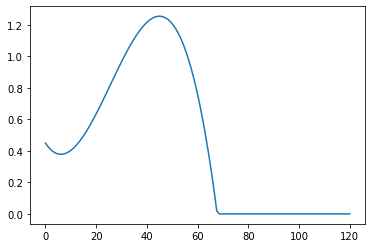

In [3]:
# whole range we want to plot
x_plot = np.linspace(0, 120, 120)

x_train = np.array([20, 25, 35, 45, 55, 65])
y_train = [17849, 26021, 32994, 35846, 33336, 8848]
# plot function
fig, ax = plt.subplots()
model = make_pipeline(PolynomialFeatures(3), Ridge(alpha=1e-3))
model.fit(x_train.reshape(-1, 1), y_train)
# I am dividing by 30000 to normalize the data
y_plot = model.predict(x_plot.reshape(-1, 1)) / 30000
y_plot[y_plot < 0] = 0
income_by_age = y_plot
ax.plot(x_plot, y_plot, label="degree 3")

In [4]:
N_STEPS = 300_000

env = lifecycle.LifecycleEnv(income_profile = income_by_age, mortality_profile = mortality_by_age)
check_env(env)
model = PPO("MlpPolicy", env, seed = 0, tensorboard_log="./runs/")

c:\Users\AS\anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [5]:
#if os.path.isfile("C:\\Users\\AS\\rep\\ucl_final_project\\life_sac.zip"):
# model = SAC.load("life_sac_v2", env=env)

eval_env = lifecycle.LifecycleEnv(income_profile = income_by_age, mortality_profile = mortality_by_age)
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/best_model', log_path='./logs/results', eval_freq=(N_STEPS/10))

model.learn(total_timesteps=N_STEPS, callback=eval_callback)
# model.save("life_sac_v2")

c:\Users\AS\rep\ucl_final_project\reinforcement\lib_for_dqn\lifecycle.py:70: RuntimeWarning: divide by zero encountered in double_scalars
  "percent_consumption": (action_consumption / self.wealth),
c:\Users\AS\anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=30000, episode_reward=0.42 +/- 44.00
Episode length: 45.00 +/- 17.91
New best mean reward!
Eval num_timesteps=60000, episode_reward=64.28 +/- 20.02
Episode length: 60.60 +/- 14.88
New best mean reward!
Eval num_timesteps=90000, episode_reward=52.69 +/- 23.92
Episode length: 52.80 +/- 18.93
Eval num_timesteps=120000, episode_reward=62.33 +/- 18.65
Episode length: 57.80 +/- 9.45
Eval num_timesteps=150000, episode_reward=54.78 +/- 33.97
Episode length: 47.80 +/- 25.01
Eval num_timesteps=180000, episode_reward=86.97 +/- 20.16
Episode length: 66.20 +/- 10.57
New best mean reward!
Eval num_timesteps=210000, episode_reward=66.12 +/- 50.39
Episode length: 69.40 +/- 7.79
Eval num_timesteps=240000, episode_reward=75.07 +/- 17.91
Episode length: 64.20 +/- 11.46
Eval num_timesteps=270000, episode_reward=65.46 +/- 22.14
Episode length: 53.00 +/- 12.47
Eval num_timesteps=300000, episode_reward=108.69 +/- 13.21
Episode length: 73.60 +/- 4.27
New best mean reward!


In [6]:
# watch trained agent
num_steps = env.terminal_age - env.starting_age + 1
info_df = pd.DataFrame(
    columns=("run", "age", "wealth", "percent_consumption", "consumption", "consumption_diff",
    "equity_allocation", "port_return", "reward"))

runs = 500
for run_number in range(runs):
    state = env.reset()
    done = False
    for step in range(num_steps):
        action, _states = model.predict(state, deterministic=True)
        state, reward, done, info = env.step(action)
        info.update(run = run_number) 
        info_df.loc[len(info_df.index)] = info
grouped_info_df = info_df.groupby('age').mean()

In [7]:
info_df[info_df.age == 115].mean()

run                    249.500000
age                    115.000000
wealth                 308.395421
percent_consumption           inf
consumption              0.838913
consumption_diff         0.010851
equity_allocation        0.855355
port_return              0.060805
reward                 -19.158609
dtype: float64

array([[<AxesSubplot:title={'center':'wealth'}>]], dtype=object)

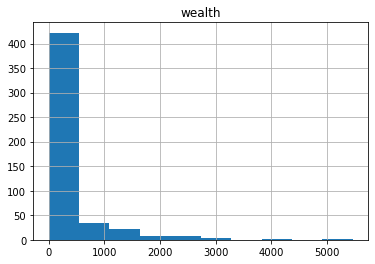

In [8]:
info_df[info_df.age == 115].hist(column='wealth')

Text(0.5, 1.0, 'Consumption')

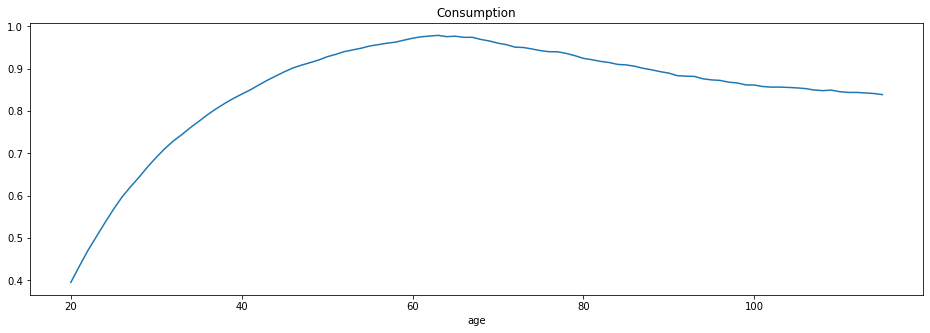

In [9]:
fig, ax = plt.subplots(nrows = 1, figsize=(16, 5))
grouped_info_df.consumption.rename("consumption").plot(ax = ax)
ax.set_title("Consumption")

Text(0.5, 1.0, 'Wealth')

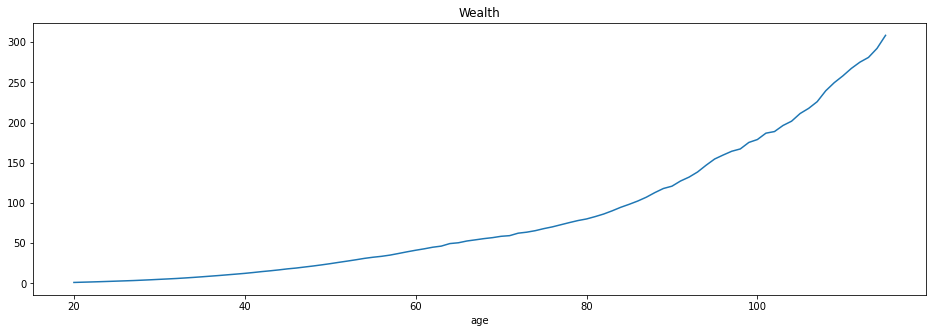

In [10]:
fig, ax = plt.subplots(nrows = 1, figsize=(16, 5))
grouped_info_df.wealth.plot(ax = ax)
ax.set_title("Wealth")

Text(0.5, 1.0, 'Equity Allocation')

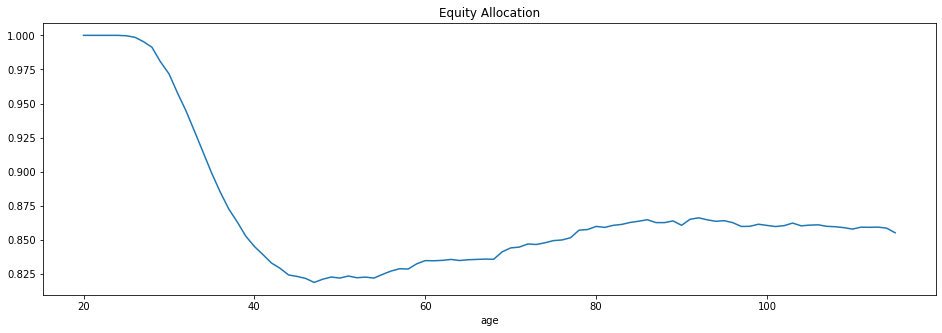

In [12]:
fig, ax = plt.subplots(nrows = 1, figsize=(16, 5))
grouped_info_df.equity_allocation.plot(ax = ax)
ax.set_title("Equity Allocation")

Text(0.5, 1.0, 'Reward')

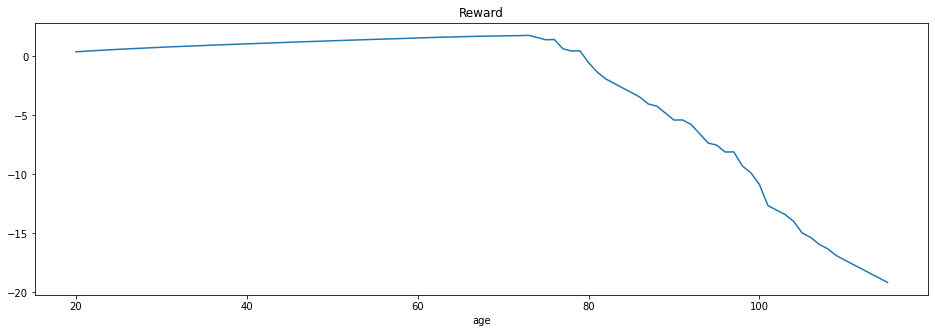

In [14]:
fig, ax = plt.subplots(nrows = 1, figsize=(16, 5))
grouped_info_df.reward.plot(ax = ax)
ax.set_title("Reward")

TypeError: 'AxesSubplot' object is not subscriptable

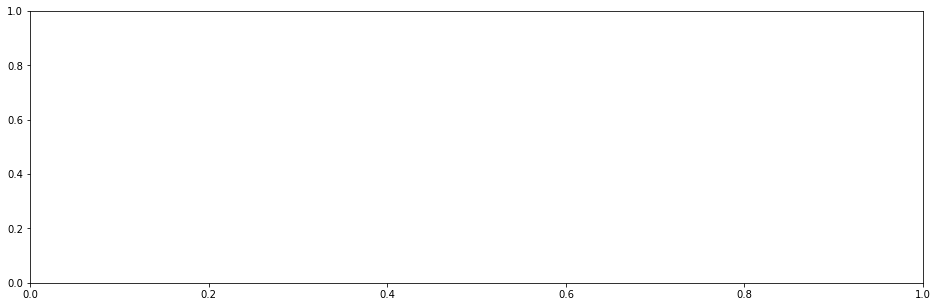

In [11]:
fig, ax = plt.subplots(nrows = 1, figsize=(16, 5))
grouped_info_df.percent_consumption.rename("percent_consumption").plot(ax = ax[1])
ax[1].set_title("% Consumption")
grouped_info_df.consumption_diff.rename("consumption_diff").plot(ax = ax[2])
ax[2].set_title("consumption_diff")


In [ ]:
grouped_info_df

,wealth,percent_consumption,consumption,consumption_diff,equity_allocation,port_return,reward
age,,,,,,,
20,1.329607,0.252609,0.333259,0.233259,0.903940,0.034256,0.333259
21,1.692052,0.216581,0.360721,0.027495,0.905640,0.050276,0.365050
22,2.090187,0.190711,0.391231,0.030790,0.916480,0.064319,0.400677
23,2.507844,0.173287,0.425235,0.034866,0.923709,0.061765,0.440728
24,2.920420,0.161999,0.461040,0.037744,0.926451,0.051330,0.483571
...,...,...,...,...,...,...,...
111,28.308510,NaN,0.801909,0.011196,0.697256,0.036131,-16.828315
112,28.569757,NaN,0.797340,0.011868,0.700250,0.046063,-17.625043
113,28.653690,NaN,0.794091,0.011728,0.698999,0.039843,-17.811148
